import libraries

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys

import project functions

### GPS data 

In [9]:
gps = pd.read_parquet('../data output/7 mixed_gps_density_month_day_hour_for_random_forest.parquet.gzip')

In [7]:
# select the hex size to work
APERTURE_SIZE = 9
hex_col = 'hex' + str(APERTURE_SIZE)

### extra features to gps 

In [8]:
poi_density = pd.read_csv('../data output/1 london_boundary_hex9_total_digi_cnt.csv')
diversity = pd.read_csv('../data output/4 london_boundary_hex9_diversity.csv') #,usecols = ['']
census = pd.read_csv('../data output/5 london_boundary_hex9_census.csv',usecols = [hex_col,'Population density km'])

In [9]:
gps = gps.merge(poi_density, how='inner', on=hex_col).\
        merge(diversity, how='inner', on=hex_col).\
        merge(census, how='inner', on=hex_col).\
        rename(columns={'total_cnt':'poi_cnt'})

In [11]:
gps.columns

Index(['hex9', 'time_cat', 'day_cat', 'month', 'gps_cnt', 'hex9_lat',
       'hex9_lon', 'num_minutes', 'year', 'weekend', 'time_num', 'time_cos',
       'time_sin', 'day_sin', 'day_num', 'day_cos', 'poi_cnt', 'shannon',
       'Population density km'],
      dtype='object')

In [12]:
len(gps)

1439544

dataset prep

In [13]:
gps_hot = gps.copy()

In [14]:
# One-hot encode the data using pandas get_dummies
gps_hot = pd.concat([gps_hot, pd.get_dummies(gps[['month']])], axis=1).drop(['month'], axis=1)

In [15]:
gps_test_list = [ #'day_cat','time_cat', # 'country', 'month',
                   'weekend',# 'year'
                   "{}_lat".format(hex_col), "{}_lon".format(hex_col),#'num_minutes', 
                   'time_num', 'time_cos', 'time_sin', 'day_num','day_cos',
                   'day_sin', 'poi_cnt', 'shannon', 'Population density km']
gps_predict_label = 'gps_cnt'

In [16]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
#https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

In [17]:
# y is the values we want to predict
y = gps_hot[gps_predict_label].values
# OR
# Labels are the values we want to predict
labels = np.array(gps_hot[gps_predict_label])

# Convert to numpy array
X = gps_hot[gps_test_list].values
# OR
# Convert to numpy array
gps_array = np.array(gps_hot[gps_test_list])

split dataset into train and test

In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels =\
#     train_test_split(gps_array, labels, test_size = 0.20) # , random_state = 42

#OR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.20) # , random_state = 42

In [19]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1151635, 12)
Training Labels Shape: (1151635,)
Testing Features Shape: (287909, 12)
Testing Labels Shape: (287909,)


In [20]:
# this isn't so important for the random forests algorithm
# they can deal well with unscaled features

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()  
# train_features = sc.fit_transform(train_features)  
# test_features = sc.transform(test_features) 

train

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 100 decision trees
reg = RandomForestRegressor(n_estimators = 100, n_jobs=-1) # , random_state = 42

# Train the model on training data
reg.fit(X_train, y_train) # OR train_features, train_labels

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

predict

In [22]:
# Use the forest's predict method on the test data
y_pred = reg.predict(X_test) #OR test_features

metrics

In [27]:
result = pd.DataFrame(y_pred,y_test).reset_index().rename(columns={'index':'real_cnt',0:'pred_cnt'})
result.sample(5)

,real_cnt,pred_cnt
216622,2,2.16
217195,6,4.69
86204,4,3.69
244249,1,1.47
243124,10,9.18


In [28]:
pd.DataFrame(abs(result.pred_cnt - result.real_cnt)).describe()

,0
count,287909.000000
mean,1.933574
std,3.109429
min,0.000000
25%,0.540000
50%,1.160000
75%,2.330000
max,460.130000


In [29]:
# # Calculate the Mean Absolute Error
# errors = abs(y_pred - y_test)
# # Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'gps events')

# # Calculate Mean Absolute Percentage Error (MAPE)
# mape = 100 * (errors / y_test)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)
# print('Accuracy:', round(accuracy, 2), '%.')

In [30]:
from sklearn import metrics

print('error units: gps events')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 

error units: gps events
Mean Absolute Error: 1.9335741154323072
Mean Squared Error: 13.40722356821079
Root Mean Squared Error: 3.6615875748383773


important features

In [31]:
import operator
dict_feat_imp = dict(zip(gps_test_list,reg.feature_importances_))

sorted_features = sorted(dict_feat_imp.items(), key=operator.itemgetter(1), reverse=True)
sorted_features

[('poi_cnt', 0.25586961398465813),
 ('hex9_lon', 0.16562504310969162),
 ('hex9_lat', 0.12468295349175212),
 ('day_num', 0.09371543467601412),
 ('shannon', 0.081444300609095),
 ('Population density km', 0.07254983980368976),
 ('time_cos', 0.06302790669420713),
 ('time_num', 0.05601375230571867),
 ('day_cos', 0.03246513611154692),
 ('day_sin', 0.026815766760115132),
 ('time_sin', 0.02585968437416047),
 ('weekend', 0.0019305680793508604)]

In [32]:
# Get numerical feature importances
importances = list(reg.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(gps_array, round(importance, 2)) for gps_array, importance in zip(gps_test_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances ] #if pair[1]>0.015

Variable: poi_cnt              Importance: 0.26
Variable: hex9_lon             Importance: 0.17
Variable: hex9_lat             Importance: 0.12
Variable: day_num              Importance: 0.09
Variable: shannon              Importance: 0.08
Variable: Population density km Importance: 0.07
Variable: time_num             Importance: 0.06
Variable: time_cos             Importance: 0.06
Variable: time_sin             Importance: 0.03
Variable: day_cos              Importance: 0.03
Variable: day_sin              Importance: 0.03
Variable: weekend              Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None]

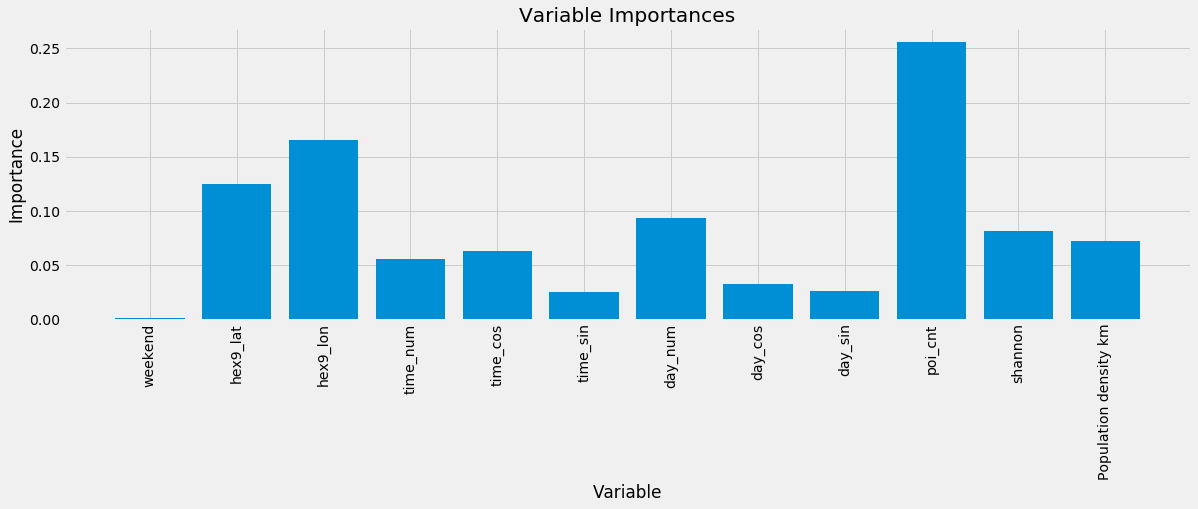

In [33]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# set the size of figure
f, ax = plt.subplots(figsize=(18,5))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, gps_test_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

check pred vs test

In [165]:
# To reduce memory consumption, we are only predicting for
# the region closely around UCL
# 51.514138,-0.151663,51.532775,-0.118189
# on a Monday
# at 13:00

area_time_to_predict_df = gps_hot[(gps_hot["{}_lat".format(hex_col)] > 51.514138) & (gps_hot["{}_lat".format(hex_col)] < 51.532775) &
        (gps_hot["{}_lon".format(hex_col)] > -0.151663) & (gps_hot["{}_lon".format(hex_col)] < -0.118189) &
        (gps_hot['time_cat']=='13:00') &
       (gps_hot['day_num'] <= 1/7.)]

test_value = area_time_to_predict_df[gps_test_list].values
test_pred_value = area_time_to_predict_df[[gps_predict_label]].values

In [14]:
pred_value = reg.predict(test_value)

In [167]:
# pd.DataFrame(test_pred_value,pred_value)
df = pd.DataFrame({'pred_cnt':pred_value})
df['actual_cnt'] = test_pred_value

In [168]:
new_area_time_to_predict_df = pd.concat([area_time_to_predict_df.reset_index(), df], axis=1)

### save it as shp to visualise in QGIS 

In [185]:
from shapely import geometry

# create a geometry column to store the geometry
new_area_time_to_predict_df['geometry'] = None

# populate the geometry column with shapely objects of the respective geohash
new_area_time_to_predict_df.geometry = new_area_time_to_predict_df.apply(lambda x:geometry.Polygon(h3.h3_to_geo_boundary(x[hex_col], geo_json=True)),axis=1)

new_area_time_to_predict_df = gpd.GeoDataFrame(new_area_time_to_predict_df, crs={'init': 'epsg:4326'}, geometry='geometry')

In [189]:
# new_area_time_to_predict_df[[hex_col, 'geometry', 'pred_cnt', 'actual_cnt']].\
#         to_file(driver = 'ESRI Shapefile', filename= "../data output/hexagons_counts_london/ucl_hex_pred_actual_cnts.shp")

### Visualize tree

In [38]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [39]:
# Limit depth of tree to 3 levels
reg_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
reg_small.fit(X_train, y_train)
# Extract the small tree
tree_small = reg_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot',filled=True, feature_names = gps_test_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');